# Python Text Analysis: Word Embeddings

<div class="alert alert-success">  
    
### Learning Objectives 

* Recognize differences between bag-of-words representations and word embeddings.
* Learn how word embeddings capture the meaning of words.
* Calculate cosine similarity to capture linguistic concepts.
* Understand that word embeddings models can be biased, and develop approaches to uncover these biases.
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
🥊 **Challenge**: Interactive excersise. We'll work through these in the workshop!<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>
🎬 **Demo**: Showing off something more advanced – so you know what Python can be used for!<br> 

### Sections
1. [Understand Word Embeddings](#section1)
2. [Word Similarity](#section2)
3. [Word Analogy](#section3)
4. [Bias in Word Embeddings](#section4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In Part 2, we have tried converting the text data to a numerical representation with a Bags of Words (BoW) representation and beyond that, a method called Term Frequency-Inverse Document Frequeny (TF-IDF). These methods make heavy use of word frequency but not much of the relative position between words, but there's still rich semantic meanings and syntactic relations left to be captured beyond independent word frequency. 

We need a more powerful tool that has the potential to represent rich semantics (and more) of our text data. In the final part of this series, we will dive into word embeddings, a method widely combined with more advanced Natural Language Processing (NLP) tasks. We'll make extensive use of the `gensim` package, which hosts a range of word embedding models, including `word2vec` and `glove`, the two models we'll explore today.

<a id='section1'></a>

# Understand Word Emebeddings 

As famously put by British Linguist J.R. Firth:

> **You shall know a word by the company it keeps.**

This quote sums it all for the essence of word embeddings, which take the numerical representation of text further to the next step. 

Recall from Part 2 that a BoW representation is a **sparse** matrix. Its dimension is determined by vocabulary size and the number of documents. Importantly, a sparse matrix like BoW is interpretable; the cell values refer to the count of a word in a document. Oftentimes the cell values are zero: many words simply don't appear in a document at all. 

We can think of word embedding as a matrix likewise, but this time a **dense** matrix, where the cell values are real numbers. Word embeddings project a word's meaning onto a high-dimensional vector space, that's why it is also called **word vectors**. A word vector is essentially an array of real numbers, the length of which, as we'll see today, could be as low as 50, or as high as 300 (or even higher in Large Language Models). These real numbers do not make explicit sense to us, but this is not to say they are meaningless. It is now believed that a word's meaning can be captured by the vector representation, which we will return to shortly.  

BOW:
- Sparse matrix
- Dimension: $D$ x $V$, where rows are **D**ocuments and columns are words in the **V**ocabulary.
- Interpretable: e.g., "bank" and "banker" may appear in a financial document, but probably not "bane."
  
<img src='../images/bow-illustration-2.png' alt="BoW" width="500">

Word embeddings:
- Dense matrix
- Dimension: $V$ x $D$, where rows are **V**ocabulary and columns are vectors with dimension **D**.
- Not immediately interpretable

<img src='../images/bow-illustration-3.png' alt="BoW" width="500">

Today, we are going to explore two widely used word embedding models, `word2vec` and `glove`. We will use the package `gensim` to access both models, so let's install gensim first.

## Install `gensim`

In [2]:
# Uncomment to install gensim
# !pip install gensim

The word embedding models hosted in `gensim` can be retrieved in two ways. We can download them using the `gensim.downloader` API; alternatively, these models can be downloaded to your local machine ahead of time, and then we use `KeyedVectors` to load them in. 

For the two models we will be working with today, we recommend downloading `word2vec` to your computer first. You can retrieve it via this [link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g). For `glove`, a smaller model, we can use the gensim API directly when we reach that section. 

In [3]:
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors

## `word2vec`

The idea of word vectors, i.e, projecting a word's meaning onto a vector space, has been around for a long time. The `word2vec` model, proposed by [Mikolov et al.](https://arxiv.org/abs/1310.4546) in 2013, introduces an efficient model of word embeddings, since then it has stimulated a new wave of research on this topic. 

The key question asked in this paper is: how do we go about learning a good vector representation from the data?

Mikolov et al. proposed two approaches: the **continuous bag-of-words (CBOW)** and the **skip-gram (SG)**. They are similar in that we use the vector representation of a token to try and predict what the nearby tokens are with a shallow neural network.   

Take the following sentence from Merriam-Webster for example. If our target token is $w_t$, "banks", the context tokens would be the preceding tokens $w_{t-2}, w_{t-1}$ and the following ones $w_{t+1}, w_{t+2}$. This example corresponds to a **window size** of 2: 2 words on either side of the target word. Similarly when we move onto the next tagret token, the context window moves as well.

<img src='../images/target_word.png' alt="Trget word" width="500">

In the continuous bag-of-words model, our goal is to predict the target token, given the context tokens. In the skip-gram model, the goal is to predict the context tokens from the target token. This is the reverse of the continuous bag-of-words and is a harder task, since we have to predict more from less information.

<img src='../images/word2vec-model.png' alt="word2vec" width="550">

**CBOW** (Left):
- **Input**: context tokens
- **Inner dimension**: embedding layer
- **Output**: the target token

**Skip-gram** (Right):
- **Input**: the target token
- **Inner dimension**: embedding layer
- **Output**: context tokens.

The above figure illustrates the direction of prediction. It also serves as a schematic representation of a neural network, i.e., the mechanism underlying the training of `word2vec`. The input and output are known to us, represented by **one-hot encodings** in Mikolov et al. The **hidden layer**, the inner dimension between the input and the output, is the vector representation that the model is trying to learn. 

Here, we provide a brief explanation of where embedding come from, but we won't go into the specifics of training a neural network. The `word2vec` model we will be interacting with today is **pretrained**, meaning that the embeddings have already been trained on a large corpus (or a number of corpora). Pretrained `word2vec` and `glove`, as well as other models, are available through `gensim`. 

Let's take a look at the list of models that `gensim` provides:

In [4]:
# Get word embedding models
gensim_models = list(api.info()['models'].keys())

for model in gensim_models:
    print(model)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


These models are named following the **model-corpora-dimension** fashion. The one called `word2vec-google-news-300` is what we are looking for! This is a `word2vec` model that is trained on Google News; the dimension of word embedding is 300. 

As mentioned previously, we can retrieve this model in two ways:
- Download it via `api.load()`
- Download the model as a zip file and then load it in with `KeyedVectors.load()`

The pretrained word2vec is archived by Google. You can download it via this Google Drive [link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g). 

In [5]:
# Run the following line if your local machine has plenty of memory
# wv = api.load("word2vec-google-news-300")

The argument `binary` asks whether the model is in the binary format. If you place the downloaded model in the `data` folder, the following file path should work.

In [6]:
# Alternatively, download the model to your machine and load it in 
wv = KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

Ta-da! Our pretrained `word2vec` is ready to use!

Accessing the actual word vectors can be done by treating the word vector model as a dictionary. 

For example, let's take a look at the word vector for "banana":

In [7]:
wv['banana']

array([-8.54492188e-02,  4.71191406e-02, -6.93359375e-02,  3.02734375e-01,
       -1.87500000e-01, -3.19824219e-02,  2.95410156e-02, -2.05078125e-01,
       -9.03320312e-02,  2.98828125e-01,  2.10937500e-01, -6.88476562e-02,
        4.76074219e-02,  5.83496094e-02, -2.75390625e-01,  2.42187500e-01,
       -3.22265625e-01,  4.73632812e-02, -1.44531250e-01,  9.37500000e-02,
        6.74438477e-03,  2.17773438e-01,  2.31445312e-01,  1.87500000e-01,
        8.49609375e-02, -5.39550781e-02, -2.65625000e-01,  2.23388672e-02,
        2.24609375e-01,  4.12109375e-01, -2.30712891e-02, -1.67968750e-01,
        1.01928711e-02,  2.10937500e-01,  1.14135742e-02,  2.50000000e-01,
        8.64257812e-02, -2.16796875e-01,  8.93554688e-02,  1.50390625e-01,
       -2.03125000e-01, -2.30468750e-01,  1.42578125e-01,  1.34765625e-01,
       -1.13769531e-01, -1.80664062e-01,  3.58886719e-02, -1.69921875e-01,
        1.55273438e-01,  2.39257812e-01, -2.30468750e-01, -9.96093750e-02,
        1.82617188e-01, -

Let's inspect the shape of the "banana" vector. 

In [8]:
wv['banana'].size

300

As promised, it is an 1-D array that holds 300 values. 

These values appear to be random floats and don't really make sense to us at the moment, but they are numerical representations on which we can perform computations. 

Let's take a look at a few examples!

<a id='section2'></a>

# Word Similarity

The first question we can ask is: what words are similar to "bank"? In vector space, we expect similar words to have vectors that are closer to each other.

There are many metrics for measuring vector similarity; one of the most widely used is [**cosine similarity**](https://en.wikipedia.org/wiki/Cosine_similarity). Orthogonal vectors have a cosine similarity of 0, and parallel vectors have a cosine similarity of 1.

`gensim` provides a function called `most_similar` that lets us find the words most similar to a queried word. The output is a tuple containing candidate words and their cosine similarities to the queried word.

Let's give it a shot!

In [9]:
wv.most_similar(['bank'])

[('banks', 0.7440759539604187),
 ('banking', 0.6901614665985107),
 ('Bank', 0.6698698401451111),
 ('lender', 0.634228527545929),
 ('banker', 0.6092953681945801),
 ('depositors', 0.6031531691551208),
 ('mortgage_lender', 0.5797975659370422),
 ('depositor', 0.5716428160667419),
 ('BofA', 0.5714625120162964),
 ('Citibank', 0.5589520931243896)]

It looks like words that are most similar to "bank" are other financial terms! 

Recall that `word2vec` is trained to capture a word's meaning based on contextual information. These words are considered similar to "bank" because they appear in similar contexts. 

In addition to querying for the most similar words, we can also ask the model to return the cosine similarity between two words by calling the function `similarity`.

Let's go ahead and check out the similarities between the following four pairs of words. In each pair, we have "river" and "bank," but the form of "bank" varies. Let's see if the different word forms make a difference!

In [10]:
# bank with capitalized B
wv.similarity('river', 'Bank')

0.07048161

In [11]:
# the present participle
wv.similarity('river', 'banking')

0.10886547

In [12]:
# the word stem
wv.similarity('river', 'bank')

0.21523127

In [13]:
# the plural form
wv.similarity('river', 'banks')

0.21918102

🔔 **Question**: Why "banks" and "river" appear to have higher similarity than other pairs?

## 🥊 Challenge 1: Dosen't Match

We have a list of coffee-noun pairs, i.e., the word "coffee" is paired with a specific coffee drink. Let's find out which coffee drink is considered most similar to "coffee," and which one is not. Complete the for loop (two cells below) to calculate the cosine similarity between each pair, i.e., make use of the `similarity` function. 

In [14]:
coffee_nouns = [
    ('coffee', 'espresso'),
    ('coffee', 'cappuccino'),
    ('coffee', 'latte'),
    ('coffee', 'americano'),
    ('coffee', 'irish'),
]

In [ ]:
for w1, w2 in coffee_nouns:
    similarity = # YOUR CODE HERE
    print(f"{w1}, {w2}, {similarity}")

On the topic of coffee, we have prepared a list of verbs commonly associated with coffee-making. Take a look at the use case for the [`doesnt_match`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#word2vec-demo) function and then use it to identify the verb that does not seem to belong.

Feel free to add more verbs to the list!

In [15]:
coffee_verbs = ['brew', 'drip', 'pour', 'make', 'grind', 'roast']

In [ ]:
verb_dosent_match = # YOUR CODE HERE
verb_dosent_match

🔔 **Question**: What have you found? Share your answers in the chat! 

<a id='section3'></a>

# Word Analogy

In addition to similarities between word pairs, one of the best known ways to use word vectors provided by `word2vec` is to solve word analogies. For example, consider the following analogy: 

`man : king :: woman : queen`

Oftentimes, word analogy like this is visualized with parallelogram, such as shown in the following figure, which is adapted from [Ethayarajh et al. (2019)](https://arxiv.org/abs/1810.04882). 

<img src='../images/word_analogy.png' alt="Word analogy" width="450">

The upper side (difference between `man` and `woman`) should approximate the lower side (difference between `king` and `queen`); the vector difference represents the meanig of `female`. 

- $\mathbf{V}_{\text{man}} - \mathbf{V}_{\text{woman}} \approx \mathbf{V}_{\text{king}} - \mathbf{V}_{\text{queen}}$

Similarly, the left side (difference between `king` and `man`) should approximate the right side (difference between `queen` and `woman`); the vector difference represents the meaning of `royal`.

- $\mathbf{V}_{\text{king}} - \mathbf{V}_{\text{man}} \approx \mathbf{V}_{\text{queen}} - \mathbf{V}_{\text{woman}}$

We can take either equation and rearrange it:

- $\mathbf{V}_{\text{king}} - \mathbf{V}_{\text{man}} + \mathbf{V}_{\text{woman}} \approx \mathbf{V}_{\text{Queen}}$

If the vectors of `king`, `man`, and `woman` are known, we can use simple vector arithmetic to obtain a vector that approximates the meaning of `queen`. This is the idea behind solving word analogies with word embeddings.

Let's implement it!

In the following operations, we use the function [`get_vector`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.get_vector) to obtain a vector from `word2vec`. The function works similarly to using a key to access its value in the `word2vec` dictionary, but it also allows us to specify whether we want to normalize the vector. 

We want to set `norm` to `True` and renormalize the difference vector later. This is because different vectors have different lengths; normalization puts them on a common scale.

In [16]:
# Calculate the vector difference for "royal"
difference = wv.get_vector('king', norm=True) - wv.get_vector('man', norm=True) 

# Add the vector for "woman"
difference += wv.get_vector('woman', norm=True)

# Renormalize 
difference = difference / np.linalg.norm(difference)

In [17]:
# What is the most similar vector?
wv.most_similar(difference)

[('king', 0.7992597818374634),
 ('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902430415153503),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236843824386597),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869)]

🔔 **Question**: The word "queen" is the second most similar one—not bad! Wait, why does "king" have the highest similarity score?

Carrying out these operations can be done in one swoop with the `most_similar` function. 

We pass in two arguments `positive` and `negative`, wherein `positive` holds the words that we want the output to be similar with, and `negative` the words we'd like the output to be dissimilar with.

In [18]:
wv.most_similar(positive=['woman', 'king'], negative='man')

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

You may have noticed that the word "king" is no longer in the result. That's because the `most_similar` function, by default, skips the input words when returning the result. This makes sense—the word itself would have the highest cosine similarity, but it is not an informative answer to our query. 

## 🥊 Challenge 2: Woman is to Homemaker?

[Bolukbasi et al. (2016)](https://arxiv.org/abs/1607.06520) is a thought-provoking investigation of gender bias in word embeddings, and they primarily focus on word analogies, especially those that reveal gender stereotyping. Let run a couple examples discussed in the paper, using the `most_similiar` function we've just learned. 

The following cell contains a few examples we can pass to the `positive` argument: we want the output to be similar to, for example, `woman` and `chairman`, and in the meantime, we are also specificying that it should be dissimilar to `man`. We'll print the top result by indexing to the 0th item. 

Let's complete the following for loop.

In [19]:
positive_pair = [['woman', 'chairman'],
                 ['woman', 'doctor'], 
                 ['woman', 'computer_programmer']]
negative_word = 'man'

In [ ]:
for example in positive_pair:
    result = # YOUR CODE HERE
    print(f"man is to {example[1]} as woman to {result[0][0]}")

🔔 **Question**: What do you find most surprising or unsurprising about the results?

<a id='section4'></a>

# Bias in Word Embeddings

### `glove` 

Any forms of stereotyping is disturbing. Now that we've known gender bias is indeed present in the pre-trained embeddings. Let's take a closer look at it!

We will switch gears to a smaller word embedding model—pretrained `glove`. Let's load it with the `api.load()` function. 

The `glove` mode we load is trained from Wikipedia and Gigaword (news data). Check out the [documentation](https://nlp.stanford.edu/projects/glove/) for more detailed model descriptions.

In [20]:
glove = api.load('glove-wiki-gigaword-50')

Let's double check the dimension of the vector, using the "banana" example again. 

In [21]:
glove['banana'].size

50

### Semantic Axis

To investigate gender bias in word embeddings, we first need a vector that captures the concept of gender. The idea is to construct **a semantic axis** (or "SemAxis") for this concept. 

The rationale for using a semantic axis is that a concept is often complex and cannot be sufficiently denoted by a single word. It is also fluid, meaning that its meaning is not definitive but can span form one end of an axis to the other. Once we have the vector representation of a concept, we can project a list of terms onto that axis to see if a term is more aligned towards one end or the other. 

We follow [An et al. 2018](https://aclanthology.org/P18-1228/) to construct a semantic axis. In preparation, we first need to come up with two sets of pole words that have opposite meanings: $\mathbf{W}_{\text{plus}}$ and $\mathbf{W}_{\text{minus}}$.

- $\mathbf{W}_{\text{plus}} = \{w_{1}^{+}, w_{2}^{+}, w_{3}^{+}, ..., w_{i}^{+}\}$

- $\mathbf{W}_{\text{minus}} = \{w_{1}^{-}, w_{2}^{-}, w_{3}^{-}, ..., w_{j}^{-}\}$

We then take the mean of each vector set to represent the core meaning of that set. 

- $\mathbf{V}_{\text{plus}} = \frac{1}{i}\sum_{1}^{i}w_{i}^{+}$

- $\mathbf{V}_{\text{minus}} = \frac{1}{j}\sum_{1}^{j}w_{j}^{-}$

Next, we take the difference between the two means to represent the semantic axis of the intended concept. 

- $\mathbf{V}_{\text{axis}} = \mathbf{V}_{\text{plus}} - \mathbf{V}_{\text{minus}}$

Projecting a specific term to the semantic axis is, as we've learned above, operationalized as taking the cosine similarity between the word's vector and the semantic axis vector. A positive value would indicate that the term is closer to the $\mathbf{V}_{\text{plus}}$ end. A negative value means proximity to the $\mathbf{V}_{\text{minus}}$ end. 

- $score(w) = cos(v_{w},  \mathbf{V}_{\text{axis}})$

With this tool, we can go ahead and construct a vector for the concept "gender"; however, this method is still limited, as gender identity in the real world cannot just be reduced to two polarities. As we proceed, we will discover how much stereotypying is encoded in gender terms.

## 🥊 Challenge 3: Construct a Semantic Axis

We have two sets of pole words for "female" and "male". These are example words tested in [Bolukbasi et al., 2016](https://arxiv.org/abs/1607.06520). We will get the embeddings for these words from `glove` to calculate the gender axis. 

The cell for the function `get_semaxis` provides some starter code. If everything runs, the embedding size of the semantic axis should be the same as the size of the input vector. 

In [22]:
# Define two sets of pole words (examples from Bolukbasi et al., 2016)
female = ['she', 'woman', 'female', 'daughter', 'mother', 'girl']
male = ['he', 'man', 'male', 'son', 'father', 'boy']

In [ ]:
def get_semaxis(list1, list2, model, embedding_size):
    '''Calculate the embedding of a semantic axis given two lists of pole words.'''

    # Step 1: Get the embeddings for terms in each list
    # w_plus = ...
    # w_minus = ...

    # Step 2: Calculate the mean embeddings for each list
    # v_plus_mean = ...
    # v_minus_mean = ...

    # Step 3: Get the difference between two means
    # sem_axis = ...

    # Sanity check
    assert sem_axis.size == embedding_size
    
    return sem_axis

In [24]:
# Plug in the gender lists to calculate the semantic axis for gender
gender_axis = get_semaxis(list1=female, 
                          list2=male, 
                          model=glove, 
                          embedding_size=50)
gender_axis

array([ 0.08418201,  0.30625182, -0.23662159,  0.02026337, -0.00296998,
        0.6195349 ,  0.01208681,  0.06963003,  0.49099812, -0.20878893,
        0.00934163, -0.44707334,  0.48806185,  0.19471335,  0.20141667,
        0.0832995 , -0.4245833 , -0.08612835,  0.47612852, -0.05129966,
        0.31475997,  0.49075842,  0.12465019,  0.26685053,  0.29776838,
        0.14211655, -0.09953564,  0.2320785 , -0.01026282, -0.30585438,
       -0.1335001 ,  0.21605133,  0.10961549, -0.03373036, -0.13584831,
       -0.12131716, -0.14671612, -0.04348468,  0.06151834, -0.3654362 ,
       -0.06193466, -0.17093089,  0.5058871 , -0.44872418,  0.05962732,
       -0.18274659,  0.24432765, -0.3396697 ,  0.00442566,  0.10554916],
      dtype=float32)

We had the gender axis ready! The next step is to project a list of terms onto the gender axis. We can continue with the occupation terms we've tested previously. 

Before we go ahead to calculate the cosine similarity, let first rate the following occupation terms, use your intuition!

The rating should be between $[-1, 1]$: the negative value means the term is closer to the male end and positive value to the female end. 

In [25]:
# Define a list of occupations terms (examples taken from Bolukbaski et al., 2016)
occupations = ['engineer',
               'nurse',
               'designer',
               'receptionist',
               'banker',
               'librarian',
               'architect',
               'hairdresser',
               'philosopher']

In [ ]:
# Rate the following occupation terms
occ_rating = {'engineer': ...,
              'nurse': ...,
              'designer': ...,
              'receptionist': ...,
              'banker': ...,
              'librarian': ...,
              'architect': ...,
              'hairdresser': ...,
              'philosopher': ...
             }

In [26]:
# Calculate cosine similarity between a given word and the axis
def get_projection(word, model, axis):
    '''Get the projection of a word onto a semantic axis'''
    
    word_norm = model[word] / np.linalg.norm(model[word])
    axis_norm = axis / np.linalg.norm(axis)
    projection = np.dot(word_norm, axis_norm) 
    
    return projection

In [ ]:
occ_projections = {word: get_projection(word, glove, gender_axis) for word in occupations}
occ_projections 

## Visualize the Projection

Now that we have calculated the projection of each occupation term onto the gender axis, let's plot these values to gain a more straightforward understanding of how much gender stereotyping is hidden in these terms.

We will use a bar plot to visualize them, with the color of each bar corresponding to the proximity of a term to an end.

In [27]:
from matplotlib.colors import Normalize

def plot_semantic_axis(projections, title, xlab):
    '''Return a horizontal bar plot of the projections.'''

    # Sort the projections in descending order
    projection_sorted = sorted(projections.items(), key=lambda term: term[1], reverse=True)

    # Extract the terms
    terms = [term_value[0] for term_value in projection_sorted]

    # Extract corresponding values of projections
    values = [term_value[1] for term_value in projection_sorted]

    # Take the absolute values for gradient color fill
    values_abs = np.abs(values)
    norm = Normalize(vmin=min(values_abs), vmax=max(values_abs))
    cmap = plt.get_cmap("YlOrBr")  
    colors = [cmap(norm(value)) for value in values_abs]

    plt.figure(figsize=(8, 6))  
    plt.barh(terms, values, color=colors)
    plt.grid(axis="x", linestyle=":", alpha=0.5)
    plt.xlim(-np.max(values_abs+0.05), np.max(values_abs+0.05))
    plt.xlabel(xlab)
    plt.title(title)
    plt.show();

We will visualize the projections as well as your self-ratings together. 

🔔 **Question**: Do you find the results surprising or expected? Let's pause for a minute to discuss why does steorotyping exist in word embeddings?

In [ ]:
title1 = 'Projections onto the gender axis'
xlab = 'Gender-stereotypical occpuation terms'
plot_semantic_axis(occ_projections, title1, xlab)

In [ ]:
# Uncomment if you have self-rated occupation terms

# title2 = 'Self-rated projections onto the gender axis'
# plot_semantic_axis(occ_rating, title2, xlab)

## 🎬 **Demo**: The Class Axis

In addition to projecting terms onto a single axis, we can also project terms onto two axes and plot the results on a scatter plot, where the coordinates correspond to projections onto the two axes.

Social class is another dimension that has been frequently discussed in the literature. In this demo, we'll create a semantic axis for social class, using two sets of pole words representing the two ends of class, as described in [Kozlowski et al. 2019](https://journals.sagepub.com/doi/full/10.1177/0003122419877135).

First, we'll project a list of sports terms onto both the gender and social class axes, similar to the method used in [Kozlowski et al. 2019](https://journals.sagepub.com/doi/full/10.1177/0003122419877135). We'll visualize the results on a scatter plot, with the x-axis representing gender and the y-axis representing social class. The coordinates of a term on this plot correspond to its projections onto these axes.

Next, we'll repeat the process to visualize occupation terms, which will give us a rough idea of how much a term is biased towards either end of these two dimensions.

Let's dive in!

In [28]:
# Define two sets of pole words of social class (examples taken from Kozlowski et. al, 2019)
poor = ['poor', 'poorer', 'poorest', 'poverty', 'inexpensive', 'impoverished', 'cheap']
rich = ['rich', 'richer', 'richest', 'affluence', 'expensive', 'wealthy', 'luxury']

class_axis = get_semaxis(list1=poor, 
                         list2=rich, 
                         model=glove,
                         embedding_size=50)

We will project sports terms onto the social class axis to see if some sports are more associated with the "high" society and others "low" soceity. 

In [29]:
# Define a list of sports terms (examples taken from Kozlowski et. al, 2019)
sports = ['camping', 
          'boxing', 
          'bowling', 
          'baseball', 
          'soccer', 
          'tennis', 
          'golf', 
          'basketball', 
          'skiing', 
          'sailing', 
          'volleyball']

Next, let's use the `get_projection` function to calculate the cosine similarity between each sport term and the axis (gender and class). 

In [30]:
proj_spt_class = {word: get_projection(word, glove, class_axis) for word in sports}
proj_spt_gender = {word: get_projection(word, glove, gender_axis) for word in sports}

Finally, let's plot the results in a scatter plot!

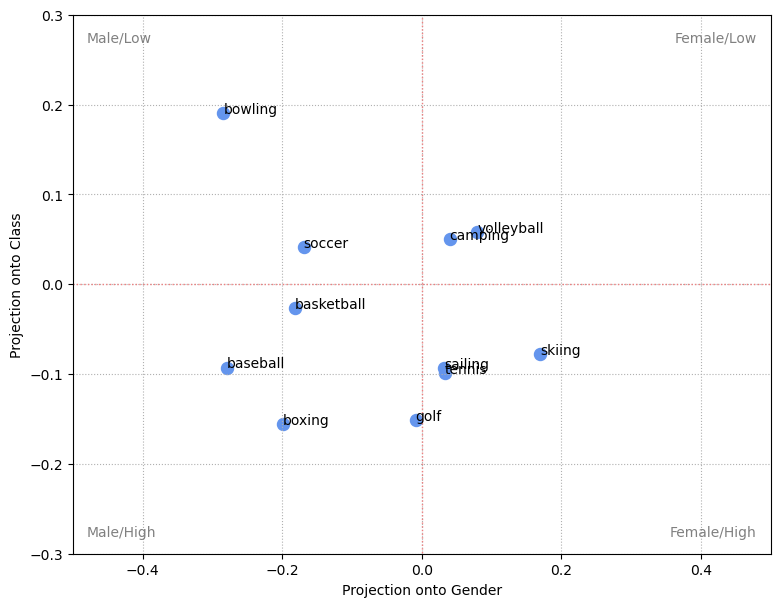

In [31]:
plt.figure(figsize=(9, 7))

# Use scatter plot to visualize the results
plt.scatter(list(proj_spt_gender.values()), 
            list(proj_spt_class.values()), 
            color='cornflowerblue',
            s=75)

# Add text label to each dot
for term in sports:
    plt.annotate(term, 
                 (proj_spt_gender[term], proj_spt_class[term]), 
                 fontsize=10)

# Add more annotations to four corners of the plot
plt.annotate('Male/High', (-0.48, -0.28), color='gray', horizontalalignment='left')
plt.annotate('Female/High', (0.48, -0.28), color='gray', horizontalalignment='right')
plt.annotate('Male/Low', (-0.48, 0.27), color='gray', horizontalalignment='left')
plt.annotate('Female/Low', (0.48, 0.27), color='gray', horizontalalignment='right')

# Add reference lines to each semantic axis
plt.hlines(xmin=-1, xmax=1, y=0, color='lightcoral', linewidth=1, linestyle=':')
plt.vlines(ymin=-1, ymax=1, x=0, color='lightcoral', linewidth=1, linestyle=':')

# Other parameter settings
plt.xlim(-0.5, 0.5)
plt.ylim(-0.3, 0.3)
plt.grid(True, linestyle=':')
plt.xlabel('Projection onto Gender')
plt.ylabel('Projection onto Class')
plt.show();

🔔 **Question**: Voilà! Our scatter plot looks great. Let's take a minute to unpack the plot and discuss the following questions:
- Which sport term is most biased towards male and which toward female?
- Which sport seems to be gender-neutral?
- Which sport term is most biased towards high social class, and which towards low social class?
- Which sport seems to be neutral to class?

Ok! Let's go back to occupation terms. We will first need to get the projections onto both axes.

In [32]:
proj_occ_gender = {word: get_projection(word, glove, gender_axis) for word in occupations}
proj_occ_class = {word: get_projection(word, glove, class_axis) for word in occupations}

Next, let's visualize the results in a scatter plot.

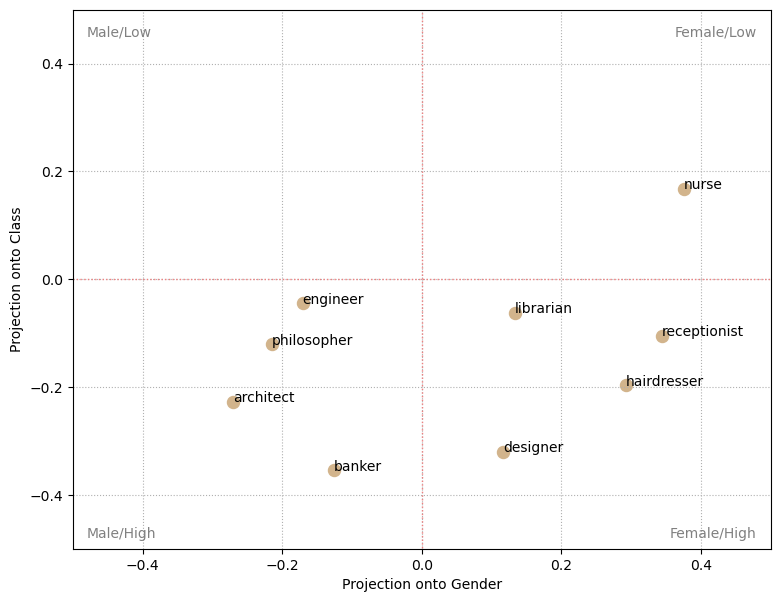

In [33]:
plt.figure(figsize=(9, 7))

# Use scatter plot to visualize the results
plt.scatter(list(proj_occ_gender.values()), 
            list(proj_occ_class.values()), 
            color='tan', 
            s=75)

# Add text label to each dot
for term in occupations:
    plt.annotate(term, 
                 (proj_occ_gender[term], proj_occ_class[term]), 
                 fontsize=10)

# Add more annotations to four corners of the plot
plt.annotate('Male/High', (-0.48, -0.48), color='gray', horizontalalignment='left')
plt.annotate('Female/High', (0.48, -0.48), color='gray', horizontalalignment='right')
plt.annotate('Male/Low', (-0.48, 0.45), color='gray', horizontalalignment='left')
plt.annotate('Female/Low', (0.48, 0.45), color='gray', horizontalalignment='right')

# Add reference lines to each semantic axis
plt.hlines(xmin=-1, xmax=1, y=0, color='lightcoral', linewidth=1, linestyle=':')
plt.vlines(ymin=-1, ymax=1, x=0, color='lightcoral', linewidth=1, linestyle=':')

# Other parameter settings
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.grid(True, linestyle=':')
plt.xlabel('Projection onto Gender')
plt.ylabel('Projection onto Class')
plt.show();

🔔 **Question**: We've known how much each term is biased towards male/female. Let's focus on their projections onto the social class axis.
- Which occuptation is most biased towards high social class, and which towards low social class?
- Which occputation seems to be neutral to class?

We will wrap up this workshop with these two plots, and hopefully, they will leave you with some food for thought to further explore word embeddings. Constructing an axis of gender or social class has been widely researched, but with the tool of semantic axis, we can investigate much more. It is useful for capturing the abstract meaning of various notions, such as an axis of coldness, an axis of kindness, and so on.

<div class="alert alert-success">

## ❗ Key Points

* Pre-trained word embeddings like `word2vec` and `glove` take contextual information into representations of words' meanings. 
* Similarities between words is conveniently reflected in cosine similarity. 
* We can explore biases in word embeddings with the methods of semantic axis.

</div>